# Subway-MTA dataset

In [193]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import csv
import datetime
import scipy
import scipy.stats

In [169]:
'''
Urls is a list of MTA Subway turnstile text files. A link to an example
MTA Subway turnstile text file
'''
urls =["http://web.mta.info/developers/data/nyct/turnstile/turnstile_110528.txt","http://web.mta.info/developers/data/nyct/turnstile/turnstile_110604.txt"]
output_file = "Subway-MTA.csv"
# Open files to save the csv requested
with open(output_file,"w") as master_file :
    writer = csv.writer(master_file)
    writer.writerow(['C/A','UNIT','SCP','DATEn','TIMEn','DESCn','ENTRIESn','EXITSn'])
    for url in urls :
        # Read files and append to the output file
        response = urllib.request.urlopen(url)
        cr = csv.reader(response.read().decode('utf-8').splitlines())
        step = 5
        init = 3 
        for k,row in enumerate(list(cr)):
            for i in range(init,len(row),step) :
                writer.writerow(row[0:init] + row[i:i+step])



In [170]:
# Open the file saved and create a dataframe
df = pd.read_csv("Subway-MTA.csv")
# Drop first colum
df.drop(df.columns[0], axis=1, inplace=True)
# Columns dataframe
df.columns

Index(['UNIT', 'SCP', 'DATEn', 'TIMEn', 'DESCn', 'ENTRIESn', 'EXITSn'], dtype='object')

In [171]:
# 5 first rows
df.head()

,UNIT,SCP,DATEn,TIMEn,DESCn,ENTRIESn,EXITSn
0,R051,02-00-00,05-21-11,00:00:00,REGULAR,3169391,1097585
1,R051,02-00-00,05-21-11,04:00:00,REGULAR,3169415,1097588
2,R051,02-00-00,05-21-11,08:00:00,REGULAR,3169431,1097607
3,R051,02-00-00,05-21-11,12:00:00,REGULAR,3169506,1097686
4,R051,02-00-00,05-21-11,16:00:00,REGULAR,3169693,1097734


## Wrangling Subway Data

In [172]:
'''
    The data in the MTA Subway Turnstile data reports on the cumulative
    number of entries and exits per row. Change
    these cumulative entry numbers to a count of entries since the last reading
    (i.e., entries since the last row in the dataframe).
'''
df['ENTRIESn_hourly'] = df['ENTRIESn'] - df['ENTRIESn'].shift(1)
df['ENTRIESn_hourly'] = df['ENTRIESn_hourly'].fillna(1)

In [173]:
'''
Change cumulative exit numbers to a count of exits since the last reading
'''
df['EXITSn_hourly'] = (df['EXITSn'] - df['EXITSn'].shift(1)).fillna(1)

In [174]:
def time_to_hour(time):
    '''
    Given an input variable time that represents time in the format of:
    "00:00:00" (hour:minutes:seconds)
    '''
    
    hour = int(time.split(':')[0])# your code here
    
        
    return hour

df['HOURn'] = df['TIMEn'].apply(time_to_hour)

In [175]:
def reformat_date(date) :
    date = datetime.datetime.strptime(date,'%m-%d-%y')
    date_formatted = datetime.datetime.strftime(date,'%Y-%m-%d')
    return date_formatted

df['DATEn'] = df['DATEn'].apply(reformat_date)

In [176]:
df.head()

,UNIT,SCP,DATEn,TIMEn,DESCn,ENTRIESn,EXITSn,ENTRIESn_hourly,EXITSn_hourly,HOURn
0,R051,02-00-00,2011-05-21,00:00:00,REGULAR,3169391,1097585,1.0,1.0,0
1,R051,02-00-00,2011-05-21,04:00:00,REGULAR,3169415,1097588,24.0,3.0,4
2,R051,02-00-00,2011-05-21,08:00:00,REGULAR,3169431,1097607,16.0,19.0,8
3,R051,02-00-00,2011-05-21,12:00:00,REGULAR,3169506,1097686,75.0,79.0,12
4,R051,02-00-00,2011-05-21,16:00:00,REGULAR,3169693,1097734,187.0,48.0,16


## Analyzing Subway Data

In [184]:
# Getting Subway Data with more information to analyze
turnstile_output_file = 'turnstile_data_master_with_weather.csv'
with open(turnstile_output_file,'w') as turnstile_file:
    turnstile_writer = csv.writer(turnstile_file)
    turnstile_content = urllib.request.urlopen('https://s3.amazonaws.com/content.udacity-data.com/courses/ud359/turnstile_data_master_with_weather.csv') 
    turnstile_reader = list(csv.reader(turnstile_content.read().decode('utf-8').splitlines()))
    for row in reader :
        turnstile_writer.writerow(row)



In [189]:
# Read new dataframe with turnstile weather data
turnstile_weather = pd.read_csv(turnstile_output_file)
# Drop unkown columns
turnstile_weather.drop(turnstile_weather.columns[0],axis=1,inplace=True)
# Print first 5 rows
turnstile_weather.head()

,UNIT,DATEn,TIMEn,Hour,DESCn,ENTRIESn_hourly,EXITSn_hourly,maxpressurei,maxdewpti,mindewpti,...,meandewpti,meanpressurei,fog,rain,meanwindspdi,mintempi,meantempi,maxtempi,precipi,thunder
0,R001,2011-05-01,01:00:00,1,REGULAR,0.0,0.0,30.31,42.0,35.0,...,39.0,30.27,0.0,0.0,5.0,50.0,60.0,69.0,0.0,0.0
1,R001,2011-05-01,05:00:00,5,REGULAR,217.0,553.0,30.31,42.0,35.0,...,39.0,30.27,0.0,0.0,5.0,50.0,60.0,69.0,0.0,0.0
2,R001,2011-05-01,09:00:00,9,REGULAR,890.0,1262.0,30.31,42.0,35.0,...,39.0,30.27,0.0,0.0,5.0,50.0,60.0,69.0,0.0,0.0
3,R001,2011-05-01,13:00:00,13,REGULAR,2451.0,3708.0,30.31,42.0,35.0,...,39.0,30.27,0.0,0.0,5.0,50.0,60.0,69.0,0.0,0.0
4,R001,2011-05-01,17:00:00,17,REGULAR,4400.0,2501.0,30.31,42.0,35.0,...,39.0,30.27,0.0,0.0,5.0,50.0,60.0,69.0,0.0,0.0


In [191]:
###  Exploratory Data Analysis

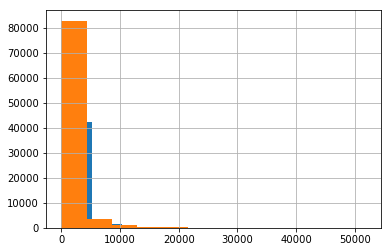

In [192]:
# Hourly entries when raining vs. when not raining
plt.figure()
turnstile_weather[turnstile_weather['rain'] == 1]['ENTRIESn_hourly'].hist()
turnstile_weather[turnstile_weather['rain'] == 0]['ENTRIESn_hourly'].hist()

plt.show()


In [198]:
# Mann-Whitney Test
U,p = scipy.stats.mannwhitneyu(turnstile_weather[turnstile_weather['rain'] == 1]['ENTRIESn_hourly'],turnstile_weather[turnstile_weather['rain'] == 0]['ENTRIESn_hourly'])
# Mann-Whitney Test
mean_with_rain = np.mean(turnstile_weather[turnstile_weather['rain'] == 1]['ENTRIESn_hourly'])
mean_without_rain = np.mean(turnstile_weather[turnstile_weather['rain'] == 0]['ENTRIESn_hourly'])

print("Mean with rain: {}, Mean without rain: {}".format(mean_with_rain,mean_without_rain))
print("U: {}, p-value: {}".format(U,p))

Mean with rain: 1105.4463767458733, Mean without rain: 1090.278780151855
U: 1924409167.0, p-value: 0.024940392294493356


I've used Mann Whitney u-Test at the NYC subway data, because the data it's not a normal distribution, so we have to use a non parametric test.

The model is used to test null hypothesis that two populations are the same using one-tail P-value. In our case, these two populations are: rainy days and non rainy days.

The result of the one tail P-critical value was: 0.25 (0.0249)